Obtaining Required Packages

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from IPython.display import display


Sample Input (Instead of doing the step below, we need to determine a way to build the dataloader pipeline)

In [2]:
img_gt_raw = Image.open('SIDD_Small_sRGB_Only/Data/0062_003_S6_03200_02500_4400_L/GT_SRGB_010.PNG')
img_n_raw = Image.open('SIDD_Small_sRGB_Only/Data/0062_003_S6_03200_02500_4400_L/NOISY_SRGB_010.PNG')


The steps below are for image processing and should be incorporated in the dataloader

In [3]:
img_gt = img_gt_raw
img_n = img_n_raw


In [4]:
img_n = img_n.resize((128,128))
img_gt = img_gt.resize((128,128))

Data Visualization

Text(0.5, 1.0, 'Noisy')

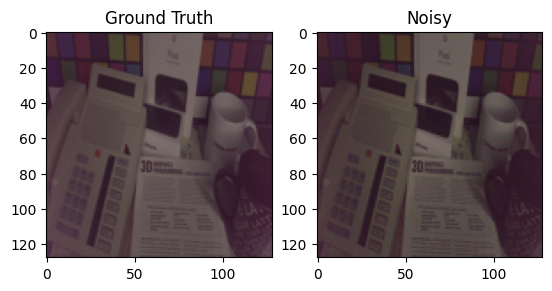

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(img_gt)
ax[0].set_title('Ground Truth')
ax[1].imshow(img_n)
ax[1].set_title('Noisy')


In [6]:
np.asarray(img_n).shape

(128, 128, 3)

Graysacling

In [7]:
img_n = ImageOps.grayscale(img_n)
img_gt = ImageOps.grayscale(img_gt)
np.array(img_n).shape

(128, 128)

Grayscale visualization

Text(0.5, 1.0, 'Noisy')

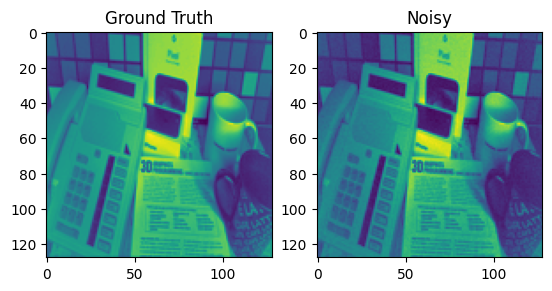

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(img_gt)
ax[0].set_title('Ground Truth')
ax[1].imshow(img_n)
ax[1].set_title('Noisy')

In [9]:
type(img_n)

PIL.Image.Image

In [10]:
np.array(img_n).shape

(128, 128)

Converting the image to tesnors

In [11]:
img_n = tf.keras.utils.img_to_array(img_n)
#Normalize
img_n =  img_n/255.0
img_n

array([[[0.19215687],
        [0.19607843],
        [0.19215687],
        ...,
        [0.17254902],
        [0.21176471],
        [0.21568628]],

       [[0.20392157],
        [0.19607843],
        [0.19607843],
        ...,
        [0.1764706 ],
        [0.21568628],
        [0.21960784]],

       [[0.19607843],
        [0.1882353 ],
        [0.19215687],
        ...,
        [0.19607843],
        [0.21176471],
        [0.20392157]],

       ...,

       [[0.18431373],
        [0.1882353 ],
        [0.21176471],
        ...,
        [0.25490198],
        [0.2509804 ],
        [0.2627451 ]],

       [[0.19215687],
        [0.1882353 ],
        [0.23529412],
        ...,
        [0.27058825],
        [0.27058825],
        [0.24705882]],

       [[0.19215687],
        [0.19215687],
        [0.24313726],
        ...,
        [0.23529412],
        [0.27058825],
        [0.26666668]]], dtype=float32)

In [12]:
img_n.shape

(128, 128, 1)

Building Generator Model

In [13]:
def generator_model():
    model = models.Sequential()
    model.add(layers.Conv2D(
        input_shape = (128,128,1), filters = 3, kernel_size = 3, padding = 'same', strides = 1, activation = layers.LeakyReLU(0.1) ))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', strides = 1, activation = layers.LeakyReLU(0.1)))
    # Will introduce more batch normalization later
    model.add(layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', strides = 1, activation = layers.LeakyReLU(0.1)))
    model.add(layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', strides = 1, activation = layers.LeakyReLU(0.1)))
    model.add(layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', strides = 1, activation = layers.LeakyReLU(0.1)))
    model.add(layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', strides = 1, activation = layers.LeakyReLU(0.1)))
    model.add(layers.Conv2D(filters = 8, kernel_size = 3, padding = 'same', strides = 1, activation = layers.LeakyReLU(0.1)))
    model.add(layers.Conv2D(filters = 3, kernel_size = 3, padding = 'same', strides = 1, activation = layers.LeakyReLU(0.1)))
    model.add(layers.Conv2D(filters = 1, kernel_size = 3, padding = 'same', strides = 1, activation = 'sigmoid'))
    return model    

In [14]:
generator = generator_model()


In [15]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 3)       30        
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     3584      
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      73792     
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      18464     
                                                        

In [16]:
img_n.shape

(128, 128, 1)

Simple Testing (Just done for 1 image; in actuality, we need to train the model which will be done through training loop)

In [17]:
generated_img = generator.predict(img_n)


4/4 [==============================] - 0s 13ms/step


In [18]:
print(generated_img.shape)
np.squeeze(generated_img).shape

(128, 128, 1, 1)


(128, 128)

Visualizing the output from the generator in 1st forward pass (No training was done till now)

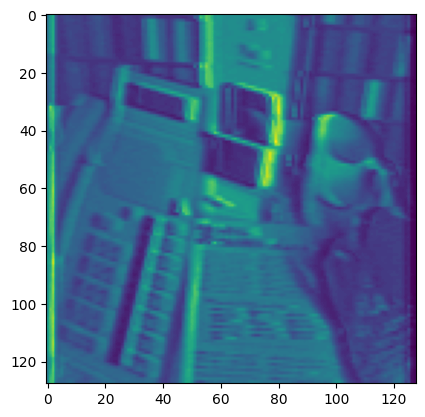

In [19]:
plt.imshow(np.squeeze(generated_img))

Building Discrimator Model

In [20]:
def discriminator_model():
    model = models.Sequential()
    model.add(layers.Conv2D(
        input_shape = (128,128,1), filters = 3, kernel_size = 3, padding = 'same', strides = 1, activation = 'relu' ))
    # Will introduct dropout later to prevent overfitting and manage simultaneous learning of generator and discriminator
    # model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', strides = 1, activation = layers.LeakyReLU(0.1)))
    model.add(layers.Conv2D(filters = 8, kernel_size = 3, padding = 'same', strides = 1, activation = layers.LeakyReLU(0.1)))
    model.add(layers.Conv2D(filters = 3, kernel_size = 3, padding = 'same', strides = 1, activation = layers.LeakyReLU(0.1)))
    model.add(layers.Conv2D(filters = 1, kernel_size = 3, padding = 'same', strides = 1, activation = 'sigmoid'))
    return model

In [21]:
discriminator = discriminator_model()

In [22]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 128, 3)       30        
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 8)       1160      
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 3)       219       
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 1)       28        
                                                                 
Total params: 1,885
Trainable params: 1,885
Non-trainable params: 0
_________________________________________________________________


In [23]:
generated_img.shape

(128, 128, 1, 1)

Data Loader and Training